### IMPORTS  FOR SKLEARN MODEL AND NLP LIBRARIES

In [79]:
import os
import numpy as np
import pandas as pd
import random
import statistics
import timeit
import itertools
from apyori import apriori
import pickle
from tools import tokenizer, clean_text
import re
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.corenlp import CoreNLPDependencyParser
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score,plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score
from config import DATABASE_FOLDER, DATABASE_FILE, FILE_JAR, FILE_MODELS_JAR
import warnings
warnings.filterwarnings("ignore")

### LOADING AND CLEANING DATASET 

In [80]:
warnings.filterwarnings("ignore")
java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path
coreNLP_path = "./stanford-corenlp-3.9.2.jar"
os.environ["CORENLP_HOME"] = coreNLP_path

if __name__ == '__main__':
    # Testing ...
    pass

TARGET           = ["Sentiment_positive"]
#TARGET           = ["Sentiment_positive"]
FEATURES         = list()
EXPLICIT_ASPECTS = set()
IMPLICIT_ASPECTS = set()

DATASET = DATABASE_FOLDER + DATABASE_FILE
data = pd.read_csv("full-corpus STS1.csv")
print(data.head())

  Sentiment  TweetId    Topic  \
0  positive        4  kindle2   
1  positive        5  kindle2   
2  positive        6  kindle2   
3  positive        7  kindle2   
4  positive        8  kindle2   

                                           TweetText  
0  Reading my kindle2...  Love it... Lee childs i...  
1  Ok, first assesment of the #kindle2 ...it fuck...  
2  @kenburbary You'll love your Kindle2. I've had...  
3  @mikefish  Fair enough. But i have the Kindle2...  
4  @richardebaker no. it is too big. I'm quite ha...  


In [81]:
def clean_text(text: str, stem = True) -> str:
    """Clear text."""

    text = re.sub(r"\W", " ", str(text))

    # Remove all single characters.
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Remove single characters from the start.
    text = re.sub(r"\^[a-zA-Z]\s+", " ", text) 

    # Substituting multiple spaces with single space.
    text = re.sub(r"\s+", " ", text, flags = re.I)

    # Removing prefixed "b"
    text = re.sub(r"^b\s+", "", text)

    # Converting to lowercase.
    text = text.lower()

    # Remove punctuation marks.
    for ch in string.punctuation:
        text = text.replace(ch, "")

    # Remove stopwords.
    text = [word for word in text.split() 
            if word not in stopwords.words("english")]
    text = " ".join(text)
    
    # Lemmatization.
    if stem:
        stemmer = WordNetLemmatizer()
        text    = text.split()
        text    = [stemmer.lemmatize(word) for word in text]
        text    = " ".join(text)

    return text


def tokenizer(text, stem = True):
    """Tokenize text."""

    text   = clean_text(text, stem)
    tokens = word_tokenize(text)

    return tokens

### UTILITY FUNCTIONS FOR ASPECTS EXTRACTION

In [82]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
def tweets_text(data):
    """Object generator from dataset tweets.
    """
    rows = data.shape[0]
    for row in range(rows):
        yield data.loc[row, "TweetText"]


def update_aspect(data, aspect, row, sentiment):
    """Update an aspect on data to sentiment.
    """
    if aspect not in data.columns:
        data[aspect] = 0.0
    data.loc[row, aspect] = sentiment


def get_sentiment(tweet_text: str) -> float:
    """Returns the sentiment of an aspect.
    """
    obj       = TextBlob(tweet_text)
    sentiment = obj.sentiment.polarity
    return sentiment


def impute_explicit_aspects(data):
    explicit_aspects = set()
    transactions = list()

    for tweet in tweets_text(data):
        transactions.append(tokenizer(tweet))
        '''
        f = open('tokens-1', 'wb')
        pickle.dump(transactions, f)
        f.close()
        '''

    # print("Printing dataset.............!!!!!!")
    # print(transactions[0:20])

    association_rules = apriori(transactions, min_support=0.1)
    unique_topics = data['Topic'].unique()

    print("Printing association rules......!!!!")
    print("Looping over!")
    for item in association_rules:
        pair = list(item[0])
        for aspect in pair:
            if aspect in unique_topics:
                explicit_aspects.add(aspect)

    print(explicit_aspects)
    # explicit_aspects -= set(["co", "http", "rt"])
    # print(explicit_aspects)

    rows = data.shape[0]
    for row in range(rows):
        tweet_tokens = tokenizer(data.loc[row, "TweetText"])
        for aspect in explicit_aspects:
            if aspect in tweet_tokens:
                tweet_text = " ".join(tweet_tokens)
                sentiment = get_sentiment(tweet_text)
                update_aspect(data, aspect, row, sentiment)

    return explicit_aspects


def impute_implicit_aspects(data):
    """Imputes implicit aspects of the dataset.
    """
    implicit_aspects = set()

    parser = CoreNLPDependencyParser(url='http://localhost:9000')

    rows = data.shape[0]
    for row in range(rows):
        printProgressBar(row,rows)
        tweet   = data.loc[row, "TweetText"]
        results = parser.raw_parse(tweet)
        words   = next(results).triples()
        aspects = set()
        for word_1, _, word_2 in words:
            aspects.add(word_1[0])
            aspects.add(word_2[0])
        aspect     = " ".join(aspects)
        aspect     = clean_text(aspect)
        implicit_aspects.add(aspect)
        sentiment  = get_sentiment(aspect)
        update_aspect(data, aspect, row, sentiment)

    return implicit_aspects


def data_preprocessing(data):
    """Data pre-processing: nominal variables to numbers (Topic and Sentiment)
    and elimination of string variables (TweetText)
    """

    topics     = pd.get_dummies(data["Topic"],  prefix = "Topic",drop_first = True)
    sentiments = pd.get_dummies(data["Sentiment"],  prefix = "Sentiment",drop_first = True)
    data       = data.drop(["Topic", "Sentiment", "TweetText"], axis = 1)

    data       = pd.concat([topics, sentiments, data], axis = 1)

    return data

def impute_overall_sentiment(data):
    """Calculates and imputes the overall sentiment index of the text
    according to aspects.
    """
  
    data["overall_sentiment"] = pd.np.nan
    #print(list(data.columns))
    aspects                   = EXPLICIT_ASPECTS | IMPLICIT_ASPECTS
    rows                      = data.shape[0]
    
    for row in range(rows):
        print(rows)
        print(float(row/rows))
        sentiments = list()
        sentiments.append(random.choice([float(data.loc[row, TARGET]), 1]))
        for aspect in aspects:
            sentiments.append(data.loc[row, aspect])

        data.loc[row, "overall_sentiment"] = statistics.mean(sentiments)

    return data


### CALCULATING IMPLICIT AND EXPLICIT ASPECTS

In [83]:
if __name__ == '__main__':
    print("")
    print(__doc__, end = "\n")
    print("* Calculating the explicit aspects of tweets using the Apriori Algorithm ...")
    EXPLICIT_ASPECTS = impute_explicit_aspects(data)
    print("* The explicit aspects obtained from this dataset are:", EXPLICIT_ASPECTS)

    print("* Calculating the Implicit Aspects of Tweets Using the SDP Algorithm ...")
    IMPLICIT_ASPECTS = impute_implicit_aspects(data)
    # print("* The implicit aspects obtained are:", IMPLICIT_ASPECTS)
    print("* Pre-processing the data before feature selection ...")
    data             = data_preprocessing(data)
    print("*Imputing overall sentiment metrics to tweets ...")
    data             = impute_overall_sentiment(data)


Automatically created module for IPython interactive environment
* Calculating the explicit aspects of tweets using the Apriori Algorithm ...
Printing association rules......!!!!
Looping over!
set()
* The explicit aspects obtained from this dataset are: set()
* Calculating the Implicit Aspects of Tweets Using the SDP Algorithm ...
* Pre-processing the data before feature selection ...███████████████████████████████████████████████-| 99.8% 
*Imputing overall sentiment metrics to tweets ...
497
0.0
497
0.002012072434607646
497
0.004024144869215292
497
0.006036217303822937
497
0.008048289738430584
497
0.01006036217303823
497
0.012072434607645875
497
0.014084507042253521
497
0.01609657947686117
497
0.018108651911468814
497
0.02012072434607646
497
0.022132796780684104
497
0.02414486921529175
497
0.026156941649899398
497
0.028169014084507043
497
0.030181086519114688
497
0.03219315895372234
497
0.03420523138832998
497
0.03621730382293763
497
0.03822937625754527
497
0.04024144869215292
497
0.

In [84]:
EXPLICIT_ASPECTS

set()

In [85]:
IMPLICIT_ASPECTS

{'1 flight san boarding hr francisco blech francisco san hour plane 6',
 '2010 south ticket going world bought world cup great africa fifa cup http bit ly 9gezi summer',
 '2day bitin shit wish every mosquito em could mosquito catch world asshole outta slowly insect insect burn',
 '2k9 http raptr com h3llgwar major baseball playing started baseball league',
 '3rd warner time bummer memorial time cable time day warner since',
 '45 pro twitter http gd smbz twitter following',
 '50d robynlyn office 50d jonduenas got u',
 '700 hardly cking tv time ball cable damn ck hd time bullshit channel come warner suck warner ever',
 '85 camera web eos http mavrev com 5a3t technology 50d brand lens new mm 5 17 canon 50d thread 15mp dslr',
 '900 thought oh wcdma freitasm mhz see',
 'aapl 12 00 updated aapl spy spx twitter pm esf buzz stock palm',
 'advice really hi get talk saying stanford video singapore jktweet saw around liked stanford yes',
 'aig loan fuck ass given aig economy hate non',
 'aig ponz

In [86]:
len(EXPLICIT_ASPECTS | IMPLICIT_ASPECTS)

497

In [87]:
data

,"Topic_""naive bayes""","Topic_""night at the museum""","Topic_""twitter api""",Topic_40d,Topic_50d,Topic_Bobby Flay,Topic_Danny Gokey,Topic_Malcolm Gladwell,Topic_aapl,Topic_aig,...,flay terrysimpson phoenix lam bflay love place great bobby pepper need favorite bobby rt,scratch amandabittner created work file great first waster time well latex latex see,wysiwyg forward editor much loving window latex using nicer linux latex looking,using hideous mathematics latex look latex typeset lot,link 1 http tinyurl com myfmf7 latex calcio1 programming indesign latex submitted ask comment,page word said kill note texn3rds come latex latex hate,environment real latex back latex text 3 ahhh editing,iran far iran hmm flockofseagullsweregeopoliticallycorrect see trouble away,iran whole iran reading incredibly terrifying tweet sad coming thing,overall_sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.003213
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.002108
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.002342
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.003146
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.002811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000
493,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,-0.8,0.0,0.00,0.000000,-0.001606
494,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.00,0.000000,0.002209
495,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.05,0.000000,-0.000100


### Sentiment Analyzer

In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(overall_sentiment):
    vs = analyzer.polarity_scores(overall_sentiment)
    return vs['positive']
    data['Vader Sentiment'] = data['overall_sentiment'].apply(vadersentimentanalysis)

### Feature Selection

In [89]:
# Import the Kernel PCA 
from sklearn.decomposition import KernelPCA
FEATURES    = list(set(data.columns) - set(TARGET))
# initialize the Kernel PCA object
kpca    = KernelPCA(n_components = 2, kernel= "rbf")# extracts 2 features, specify the kernel as rbf
X       = StandardScaler().fit_transform(data)
principal_components  = kpca.fit_transform(X)
kpca_data             = pd.DataFrame(data =  principal_components ,columns = ["Principal Component1","Principal Component2"])
kpca_data             = pd.concat([kpca_data, data[TARGET]], axis = 1)


In [90]:
kpca_data

,Principal Component1,Principal Component2,Sentiment_positive
0,-0.152254,-0.051438,1
1,-0.150589,-0.042227,1
2,-0.150860,-0.044202,1
3,-0.152125,-0.050887,1
4,-0.151535,-0.048124,1
...,...,...,...
492,0.328154,0.052462,0
493,-0.180403,0.052329,0
494,-0.181830,-0.009065,1
495,-0.208827,0.058128,0


In [96]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='tab20')
    classNames = ['Incorrectly Classified','Correctly Classified']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center' 
                     )
    plt.show()

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
 #Training and testing split
x_train1, X_test, y_train1, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [99]:
models = []
models.append(('MLP', MLPClassifier(activation = 'tanh',alpha=1,max_iter=1000)))
models.append(('SVM', SVC(probability=True)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(max_depth=5)))
models.append(('NB', GaussianNB()))
models.append(('xgb', XGBClassifier(random_state=0, learning_rate =0.01,n_estimators=100)))





MLPClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 96.0000%


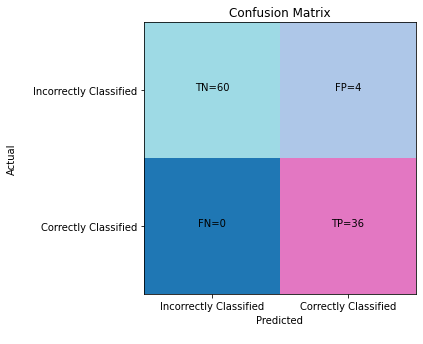





SVC Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 94.0000%


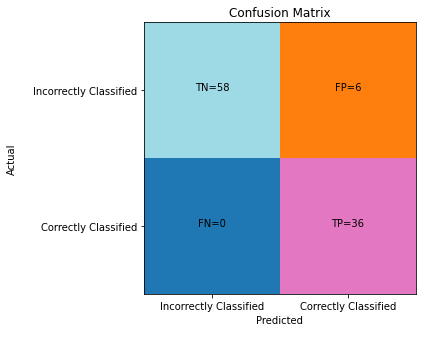





KNeighborsClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 95.0000%


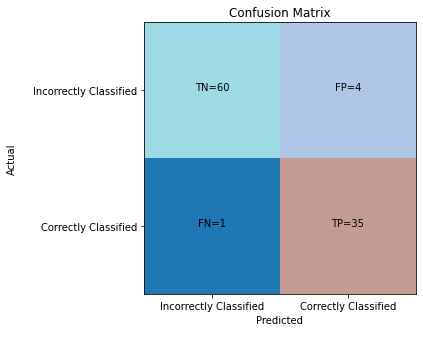





DecisionTreeClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 94.0000%


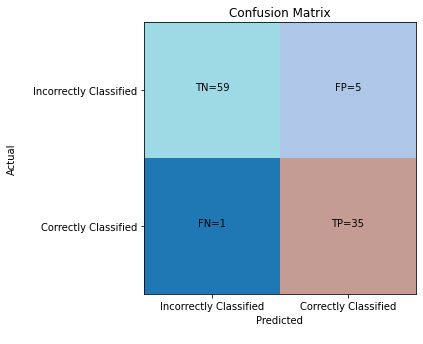





GaussianNB Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 92.0000%


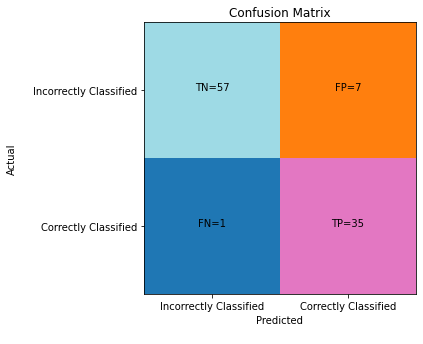

[13:12:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.




XGBClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 95.0000%


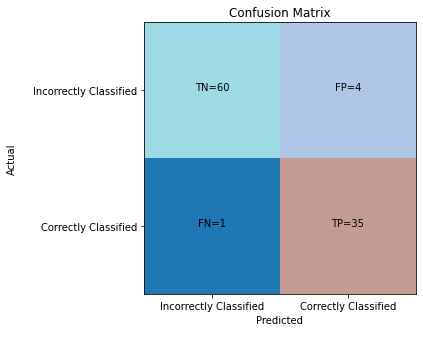

****************************************


In [100]:
  #putting results in df
res_cols=["Classifier", "Accuracy", "Recall", "Roc Auc","F1","Precision","Execution Time"]
results = pd.DataFrame(columns=res_cols)

for name, model in models:
    model.fit(x_train1, y_train1)
    name = model.__class__.__name__
    y_pred = model.predict(X_test)

    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    

    start_time = timeit.default_timer()
    cm = confusion_matrix(y_test, y_pred)
    
    cm_plot(cm)
    
    rec= recall_score(y_test, y_pred)
    roc=roc_auc_score(y_test, y_pred)
    f1s=f1_score(y_test, y_pred)
    pre=precision_score(y_test, y_pred)
    results_final = pd.DataFrame([[name, round(acc*100,2), 
                                    round(rec*100,2), round(roc*100,2),
                                   round(f1s*100,2),round(pre*100,2),format(timeit.default_timer() - start_time)]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [101]:
results.head(20)

,Classifier,Accuracy,Recall,Roc Auc,F1,Precision,Execution Time
0,MLPClassifier,96.0,100.00,96.88,94.74,90.00,0.15117880000002515
0,SVC,94.0,100.00,95.31,92.31,85.71,0.15134299999999712
0,KNeighborsClassifier,95.0,97.22,95.49,93.33,89.74,0.17029520000005505
0,DecisionTreeClassifier,94.0,97.22,94.70,92.11,87.50,0.1612056000001303
0,GaussianNB,92.0,97.22,93.14,89.74,83.33,0.3594565999999304
0,XGBClassifier,95.0,97.22,95.49,93.33,89.74,0.17182019999995646


In [102]:
import sklearn.metrics
import sklearn.metrics as metrics

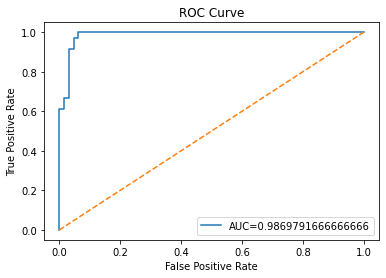

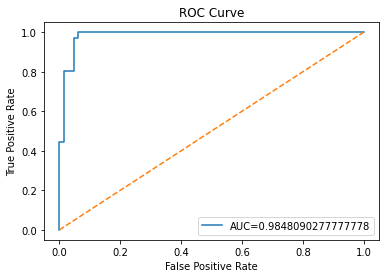

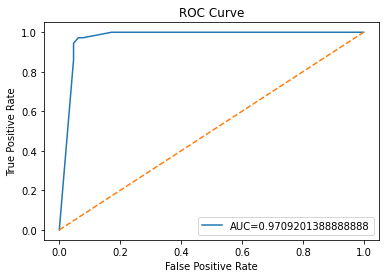

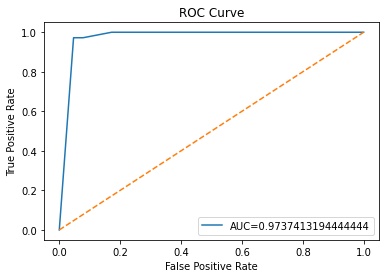

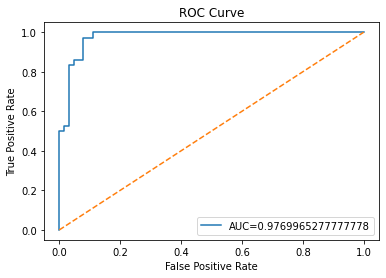

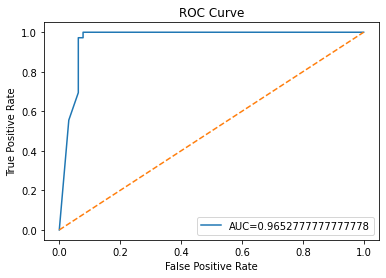

In [103]:
for name,model in models:
#define metrics
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
    plt.title('ROC Curve')
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

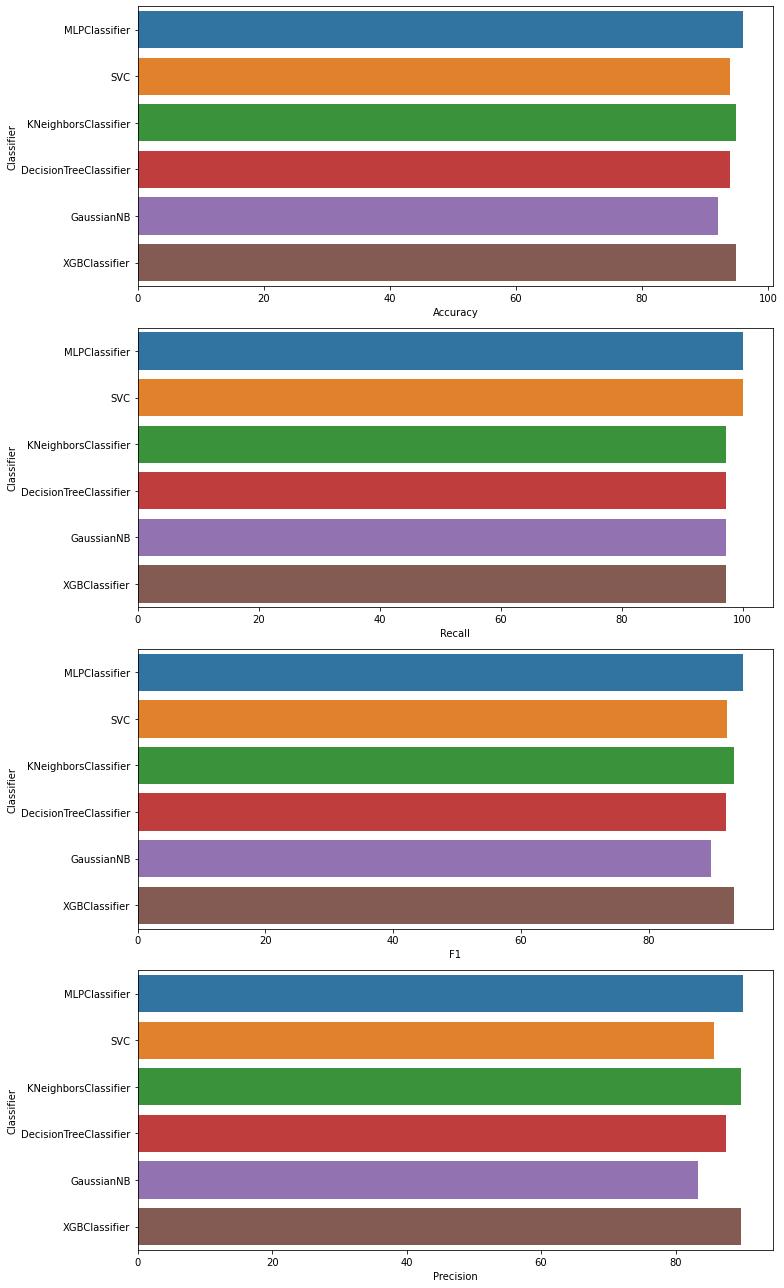

In [104]:
#Visualize scores for all model
fig, ax =plt.subplots(nrows=4, ncols=1, figsize = (11,18))
sns.barplot(x='Accuracy', y='Classifier', data=results, ax=ax[0])
sns.barplot(x='Recall', y='Classifier', data=results, ax=ax[1])
sns.barplot(x='F1', y='Classifier', data=results, ax=ax[2])
sns.barplot(x='Precision', y='Classifier', data=results, ax=ax[3])
plt.tight_layout()
plt.show()